# Project 3: CHIPseq
Name: Iris Lee  
ID: U05303694

In [6]:
import warnings
warnings.filterwarnings('ignore')

## Introduction

Chromatin organization plays a fundamental role in regulating gene expression, particularly through the spatial arrangement of promoters, enhancers, and transcription factor binding sites. RUNX1 is a transcription factor known for its involvement in hematopoietic differentiation and has also been implicated in breast cancer progression, where it can act as either a tumor suppressor or oncogenic driver. Barutcu et al. (2016) [[ref]](https://doi.org/10.1016/j.bbagrm.2016.08.003) investigated how RUNX1 contributes to the higher-order chromatin architecture of breast cancer cells by integrating ChIP-seq with Hi-C and gene expression analyses. The study aimed to determine whether RUNX1 binding sites are associated with chromatin loop anchors and transcriptionally active genomic regions, which influences cancer-specific gene regulation as a result. Bioinformatic techniques, including sequence quality control, alignment, peak calling, annotation, and motif discovery, were used to map RUNX1 occupancy across the genome and identify enriched sequence motifs and target genes. These computational approaches produced high-resolution mapping of RUNX1-associated chromatin domains and provided insights into how this transcription factor may coordinate chromatin topology and transcription regulation in breast cancer cells.

## Methods

### Source of Data
Raw ChIP-seq data corresponding to RUNX1 immunoprecipitation (IP) and matching input control samples were obtained from the dataset described in Barutcu et al. (2016). The human reference genome (GRCh38) and its annotation GTF file were downloaded from Ensembl release 115. The single-end reads were formatted and imported into the workflow via Nextflow channels.  

### Quality Control and Read Trimming
Initial quality control of single-end read sequences was performed via FASTQC v0.12.1 [[ref]](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) with default parameters. FASTQC outputted HTML reports (`*.html`), which included statistics on per-base sequence quality, GC content, and adapter contamination. Adapter sequences were removed and low-quality bases were trimmed using Trimmomatic v0.39 [[ref]](http://www.usadellab.org/cms/?page=trimmomatic) with the single-end parameters `ILLUMINACLIP:${adapter_fa}:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36`. The trimmed FASTQ files were subsequently used for downstream analysis.  

### Genome Indexing and Alignment
The human reference genome (GRCh38) was indexed via Bowtie2 v2.5.4 [[ref]](https://bowtie-bio.sourceforge.net/bowtie2/manual.shtml) with default parameters via the `bowtie2-build` command. Trimmed reads were aligned to the indexed genome using Bowtie2 in single-end mode with default parameters. Output SAM files were converted to BAM format using Samtools v1.21 [[ref]](https://www.htslib.org/) and sorted via `samtools sort` with default parameters. BAM indices were generated using `samtools index` with default parameters. Alignment quality metrics, including the number and percentage of mapped reads, were calculated using `samtools flagstat` with default parameters. FASTQC, Trimmomatic, and Samtools Flagstat outputs were compiled via MultiQC v1.25 [[ref]](https://seqera.io/multiqc/) with the parameter `-f .` into a single HTML report of sequence quality and summary statistics.  

### Coverage and Correlation Analysis
Normalized coverage BigWig files (`.bw`) were generated via deepTools v3.5.5 [[ref]](https://deeptools.readthedocs.io/en/latest/) via the deepTools `bamCoverage` command with default parameters. These BigWig files were aggregated and summarized via the deepTools `multiBigwigSummary` command with the `bins` parameter to calculate pairwise correlations between samples. 
Correlation heatmaps and scatterplots were produced via the deepTools `plotCorrelation` command with the parameter `-c pearson`, providing a visual assessment of sample reproducibility and similarity.  

### Tag Directory Creation and Peak Calling
For peak detection, HOMER v4.11 [[ref]](http://homer.ucsd.edu/homer/) was used to create tag directories for each aligned BAM file using the HOMER `makeTagDirectory` command with default parameters. Each immunoprecipitated (IP) tag directory was paired with its corresponding input control directory based on replicate identifiers. Peak calling was performed via the HOMER `findPeaks` command with the ChIP-seq mode parameter `-style factor` with input control normalization. Peak output files in TXT format (`*.txt`) were converted to BED format using the HOMER `pos2bed.pl` command with default parameters to facilitate downstream analyses.  

### Reproducibility Assessment of Peaks
To identify reproducible peaks across biological replicates, BED-formatted peak files were intersected via BEDTools v2.31.1 [[ref]](https://bedtools.readthedocs.io/en/latest/) via the `bedtools intersect` with the `-f 0.5` parameter, retaining peaks shared between replicates. Blacklisted regions defined by the Boyle Lab of the ENCODE Consortium [[ref]](https://github.com/Boyle-Lab/Blacklist) were removed using `bedtools subtract` with default parameters to minimize false positives arising from artifact-prone genomic regions.  

### Peak Annotation
Filtered peak sets were annotated using the HOMER `annotatePeaks.pl` command with the reference genome (GRCh38) and corresponding GTF annotation file. Each peak was assigned to the nearest gene, promoter, or genomic feature, allowing functional interpretation of RUNX1 binding sites. 

### Signal Profiling
To assess read enrichment across gene bodies, we used the deepTools `computeMatrix` command with the `scale-regions` parameter, UCSC gene annotation reference, and a window size of 2000 both upstream of the start site and downstream of the end site. Signal profiles of RUNX1 ChIP-seq samples were visualized using the deepTools `plotProfile` with default parameters, showing average ChIP signal distribution across all annotated genes.  

### Motif Enrichment Analysis
Motif discovery within reproducible RUNX1 peak regions was performed using the HOMER `findMotifsGenome.pl` command with the reference genome (GRCh38) and default parameters. Enriched motifs were reported based on known transcription factor binding site databases. This analysis identified consensus DNA motifs associated with RUNX1 binding and potential co-regulatory transcription factors.

## Quality Control Evaluation

Based on the MultiQC report and accompanying QC metrics from FASTQC, Trimmomatic, and `samtools flagstat`, the sequencing reads appear to be of generally high quality. Below is a table outlining total numbers as well as percentages of mapped reads based on `samtools flagstat`:  

| Sample Name    | Mapped Reads | % of Mapped Reads |
| -------- | ------- | ------- |
| IP_rep1  | 27,788,333 | 96.76% |
| IP_rep2 | 28,197,249 | 98.30% |
| INPUT_rep1 | 28,578,769 | 96.10% |
| INPUT_rep2 | 10,055,226 | 93.55% |
  
FASTQC flagged no major quality issues aside from duplication levels, which were low in the INPUT control samples (10.6–13.0%) and expectedly high in the IP samples (74.3–89.1%) due to enrichment inherent to ChIP-like assays. Samples had minimal adapter contamination (<3%). Trimmomatic trimming performance was strong, with high percentages of surviving reads across all samples (95.6–98.9%). MultiQC detected only two overrepresented sequences in the IP samples, each present at low levels (2.10–3.13%), suggesting no substantial contamination or artifact. Based on this evaluation, we believe that the sequence runs and library preparations were successful, and the experiment was of high quality and thus suitable for downstream analyses.

## Signal Coverage Plot

Our signal coverage plots generated from deepTools `computeMatrix` and `plotProfile` are below:

![IP_rep1 Signal Coverage Plot](/projectnb/bf528/students/ihlee14/project-3-ihlee-1014/results/plotprofile/IP_rep1_signal_coverage.png)  

![IP_rep2 Signal Coverage Plot](/projectnb/bf528/students/ihlee14/project-3-ihlee-1014/results/plotprofile/IP_rep2_signal_coverage.png)  

These plots represent aggregated ChIP-seq signal profiles centered around gene bodies that span 2 kb upstream of the transcription start site (TSS) to 2 kb downstream of the transcription end site (TES). Each curve shows the average normalized read coverage across all annotated genes for each IP replicate. A prominent peak is shown right at the TSS, followed by a sharp decline in signal as the profile moves downstream from the gene body. Since the signal coverage plots of IP_rep1 and IP_rep2 look almost identical, we can confirm that the consistency of this pattern indicates strong reproducibility between biological replicates.  

Biologically, this pattern suggests that the immunoprecipitated factor is highly enriched at or immediately adjacent to promoters, especially at transcription start sites. A strong TSS-centered peak is associated with transcription factors or chromatin-associated proteins that have functions including regulating transcription initiation, recruiting the transcriptional machinery, and interacting with promoter-associated chromatin marks. The minimal signal across gene bodies and downstream regions further supports a model in which this factor functions primarily at promoters rather than in elongation or regulatory regions that are further away. Thus, we can safely assume that RUNX1 plays a direct role in regulating gene expression near the promoter region.


## Motif Finding

Below is a screenshot of the top results from the "knownResults" output from HOMER `findMotifsGenome`:

![knownResults Top Results](/projectnb/bf528/students/ihlee14/project-3-ihlee-1014/results/findmotifsgenome/top_HOMER_knownresults.png)  

The output shows a strong enrichment of motifs that aligns closely with the Barutcu et al. (2016) research. The top four motifs are all RUNX-family motifs, derived from multiple independent RUNX1, RUNX2, and RUNX-enriched ChIP-seq datasets. Their strong enrichment indicates that the peaks identified in the experiment are highly enriched for canonical Runt-domain binding sites, which strongly supports that the immunoprecipitated factor binds DNA either as a RUNX protein or is strongly associated with RUNX-dependent regulatory regions.  

Furthermore, motifs ranked 5-9 belong to the AP-1/bZIP family (Fosl2, Fra2, Fos, JunB, Fra1), suggesting that there is potential co-binding between RUNX factors and AP-1 complexes. RUNX-AP-1 interactions are well-documented in several cellular contexts, particularly in gene regulatory programs involving differentiation, proliferation, and stress signaling. The co-enrichment of these motifs suggests that RUNX may function together with AP-1 proteins at shared enhancers or promoters in this system. The motif at rank 10, GRHL2, is also interesting since GRHL2 often marks epithelial-specific enhancers and may indicate a lineage-specific regulatory environment in which RUNX factors act.  

Overall, these results support a biologically coherent system where RUNX factors occupy promoter/enhancer regions, possibly in collaboration with AP-1 family transcription factors.

## Overlapping ChIP-seq results with the original RNAseq data

Using our annotated peaks and the original paper's RNA-seq results, we will recreate the paper's Figure 2F below:

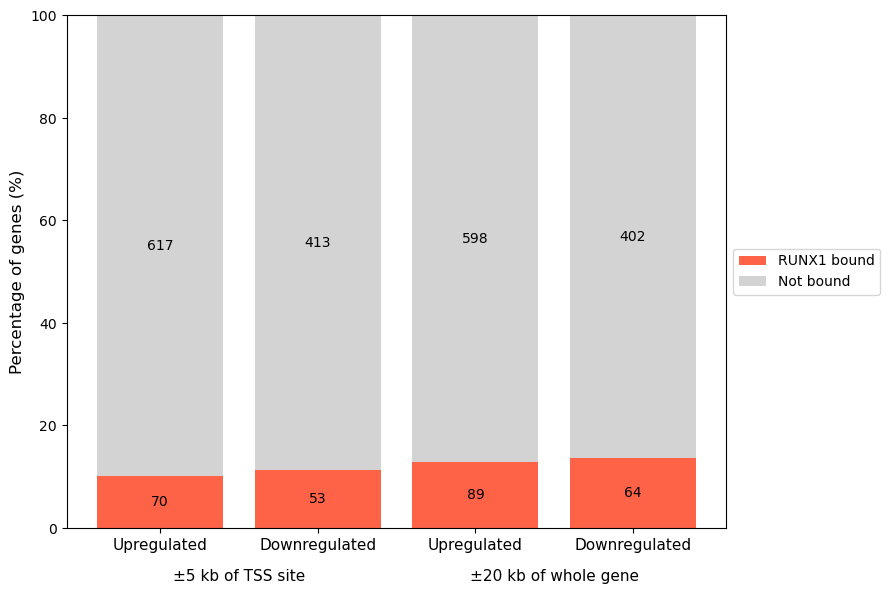

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load annotated reproducible and filtered peaks and original paper rnaseq results
annotated_peaks = pd.read_csv("results/annotatepeaks/annotated_peaks.txt", sep="\t")
og_rnaseq = pd.read_csv("results/PAPER_RESULTS/GSE75070_MCF7_shRUNX1_shNS_RNAseq_log2_foldchange.txt",sep="\t")

# preprocess peak file
peaks = annotated_peaks.copy()
peaks["Gene Name"] = peaks["Gene Name"].astype(str)
peaks["Distance to TSS"] = pd.to_numeric(peaks["Distance to TSS"], errors="coerce")

# genes with peaks +/- 5 kb of TSS 
genes_5kb = set(peaks[peaks["Distance to TSS"].abs() <= 5000]["Gene Name"].dropna())

# genes with peaks +/- 20 kb of whole gene
genes_20kb = set(peaks[peaks["Distance to TSS"].abs() <= 20000]["Gene Name"].dropna())

# process rnaseq table
rna = og_rnaseq.dropna(subset=["log2FoldChange"])
up = rna[(rna["log2FoldChange"] > 1) & (rna["padj"] <= 0.01)]
down = rna[(rna["log2FoldChange"] < -1) & (rna["padj"] <= 0.01)]
up_genes = set(up["genename"])
down_genes = set(down["genename"])

# helper function to count bound vs. not bound
def count_bound(gene_set, binding_set):
    bound = len([g for g in gene_set if g in binding_set])
    not_bound = len(gene_set) - bound
    return bound, not_bound

# use helper to compute all 4 bars
up_5kb_bound, up_5kb_not = count_bound(up_genes, genes_5kb)
down_5kb_bound, down_5kb_not = count_bound(down_genes, genes_5kb)
up_20kb_bound, up_20kb_not = count_bound(up_genes, genes_20kb)
down_20kb_bound, down_20kb_not = count_bound(down_genes, genes_20kb)

# prepare plotting df
plot_df = pd.DataFrame({
    "Category": ["Upregulated", "Downregulated", "Upregulated", "Downregulated"],
    "RUNX1 bound": [up_5kb_bound, down_5kb_bound, up_20kb_bound, down_20kb_bound],
    "Not bound": [up_5kb_not, down_5kb_not, up_20kb_not, down_20kb_not]
})

# convert counts to %
plot_df["Total"] = plot_df["RUNX1 bound"] + plot_df["Not bound"]
plot_df["Bound_pct"] = plot_df["RUNX1 bound"] / plot_df["Total"] * 100
plot_df["Not_pct"] = plot_df["Not bound"] / plot_df["Total"] * 100

# plotting
fig, ax = plt.subplots(figsize=(9, 6))
x = np.arange(len(plot_df))

# set colors
ax.bar(x, plot_df["Bound_pct"], color="tomato", label="RUNX1 bound")
ax.bar(x, plot_df["Not_pct"], bottom=plot_df["Bound_pct"], color="lightgray", label="Not bound")

# add counts on bars
for i in range(len(plot_df)):
    ax.text(i, plot_df["Bound_pct"][i] / 2, str(plot_df["RUNX1 bound"][i]), ha="center", va="center", fontsize=10, color="black")
    ax.text(i, plot_df["Bound_pct"][i] + plot_df["Not_pct"][i] / 2, str(plot_df["Not bound"][i]), ha="center", va="center", fontsize=10, color="black")

# set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(plot_df["Category"], fontsize=11)

# set shared x-axis labels
y_offset = -0.08
ax.annotate("±5 kb of TSS site", xy=(0.5, y_offset), xycoords=("data", "axes fraction"), ha="center", va="top", fontsize=11)
ax.annotate("±20 kb of whole gene", xy=(2.5, y_offset), xycoords=("data", "axes fraction"), ha="center", va="top", fontsize=11)

# formatting
ax.set_ylabel("Percentage of genes (%)", fontsize=12)
ax.set_ylim(0, 100)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

If we compare this barplot to the paper's Figure 2F, we can see that they have broadly similar patterns, but the exact numbers of RUNX1-bound genes and non-bound genes differ between the two heatmaps. Although both barplots used the same log2 fold change and adjusted p-value thresholds (log2FC > 1, padj <= 0.01), our barplot shows fewer RUNX1-bound genes within +/-20kb of the whole gene compared to the original barplot.

One reason for this difference could be a difference in gene annotation strategies, which can influence which genes are considered to overlap with RUNX1 peaks. For instance, the original paper may have used an annotation source that included all transcript isoforms when defining gene boundaries or extended gene models to incorporate known regulatory regions. On the other hand, our analysis used the HOMER `annotatePeaks.pl` command, which bases assignments on a single "nearest gene" rather than the full span of all isoforms. The authors of the original paper may have also counted multiple peaks per gene.

We will now reproduce the paper's Figures 2D and 2E using our list of filtered and reproducible peaks from `bedtools remove`, our bigWig files from `deepTools bamcoverage`, and the IGV genome browser:

![MALAT1 IGV](/projectnb/bf528/students/ihlee14/project-3-ihlee-1014/results/malat1-igv-app.png)  

![NEAT1 IGV](/projectnb/bf528/students/ihlee14/project-3-ihlee-1014/results/neat1-igv-app.png)  

As shown by our IGV tracks, our results do detect reproducible, statistically supported RUNX1 ChIP-seq peaks within both the MALAT1 and NEAT1 genes, which is consistent with the original paper's original figures. In our IGV tracks, the IP tracks show clear enrichment over background, and our reproducible-peak BED tracks mark peaks in approximately the same regions in the paper's figures. Minor differences, including variations in peak height, background input signal, or exact peak boundaries, may arise from differences in sequencing depth, mapping pipelines, or normalization methods.

## Comparing key findings to the original paper

Using our results from MultiQC, we will recreate the paper's Supplementary Figure S2A below:  

| Sample Name    | Biological Replicate | Raw Reads | Mapped Reads |
| -------- | ------- | ------- | ------- |
| IP_rep1  | 1    | 28,717,962 | 27,788,333 |
| IP_rep2 | 2     | 28,683,573 | 28,197,249 |
| INPUT_rep1 | 1     | 29,738,984 | 28,578,769 |
| INPUT_rep2 | 2     | 10,748,718 | 10,055,226 |
  
Comparing our read count results to those of Barutcu et. al (2016), we can see that the total number of raw reads is highly similar across corresponding samples, but the number of mapped reads differs more noticeably. Our dataset consistently shows higher alignment rates, and these differences can be caused by several reasons. First, differences in alignment tools and versions can substantially affect mapping efficiency. Our workflow uses Bowtie2 v2.5.4 with default parameters, and the original study may have used an earlier version of Bowtie2 that was more conservative in handling mismatches or multi-mapping reads. Second, preprocessing strategies such as trimming, adapter removal, or quality filtering strategies can also alter the number of reads retained for alignment and thus the number of reads that are eventually mapped. Other factors may include updates to the reference genome (i.e. hg38 vs. hg19), variations in how PCR duplicates or low-quality alignments are treated, and changes in how reads are filtered or counted in recently updated bioinformatic tools.

Our correlation plot generated from deepTools `plotCorrelation` is below:

![Correlation Plot](/projectnb/bf528/students/ihlee14/project-3-ihlee-1014/results/plotcorelation/correlation_plot.png)

The paper's correlation heatmap and our correlation heatmap both show similar clustering of RUNX1 ChIP replicates with one another, as well as clustering of INPUT control replicates with one another. There is also a clear separation between RUNX1 ChIP samples and INPUT control samples in both heatmaps. These similarities indicate that the experiment effectively captured RUNX1-specific chromatin signal. Any slight differences may be due to updates in bioinformatic tools or hg38 genome usage instead of the genome used in 2016. Overall, both heatmaps show that replicates exhibit strong clustering, different samples are separated, and the correlation structure is consistent.


Using our outputs from HOMER `findPeaks` and our annotated peaks, we will recreate the paper's Supplementary Figure S2C below:

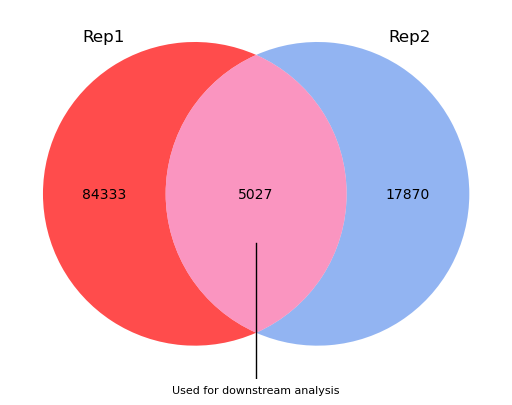

In [8]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted

# create venn diagram
v = venn2_unweighted(subsets = (84333, 17870, 5027),
                 set_labels = ('Rep1', 
                               'Rep2'),
                 set_colors=("red",
                             "cornflowerblue"),alpha=0.7)

# position labels
if v.get_label_by_id('A'):
    v.get_label_by_id('A').set_position((-0.4, 0.5)) # Adjust (x, y) as needed
if v.get_label_by_id('B'):
    v.get_label_by_id('B').set_position((0.4, 0.5))

# make vertical line
line_y_top = -0.15   # adjust if needed
line_y_bottom = -0.65

plt.plot([0, 0], [line_y_top, line_y_bottom], color="black", linewidth=1)

# add caption under the line
plt.text(0, -0.58, "Used for downstream analysis",
         ha='center', va='top', fontsize=8)

plt.show()

Comparing our Venn diagram with the paper's Supplementary Figure S2C, we can see that there is a notable difference in the number of peaks identified for each replicate, as well as the size of overlapped peaks used for downstream analysis. In general, the paper's Venn diagram has substantially smaller numbers of peaks. Similar to differences in other plots, updates in genomes, annotation files, or peak-calling software versions can create differences in how peaks are filtered or merged, which eventually affect the resulting peak totals. Preprocessing pipelines may also contribute to these differences.

## Analysis of Annotated Peaks

To analyze our annotated peaks, we will use Stanford's GREAT (Genomic Region Enrichment Annotation Tool). We input our BED file of filtered and reproducible peaks from `bedtools subtract` as the test set, used the whole genome as the background, used the human GRCh38 (hg38) for the assembly, and the basal+extension with +/-5.0 kb from the promoter and 1000 kb max extension. Below is a table of the top 10 GO biological pathways from our GREAT results:  

| Term Name | Binom Raw P-Value | Binom Observed Region Hits | Binom Region Set Coverage | Hyper Observed Gene Hits | Hyper Gene Set Coverage |
|-----------|--------------------|-----------------------------|-----------------------------|----------------------------|---------------------------|
| placenta development | 4.620564e-17 | 158 | 0.03143028 | 69 | 0.01259584 |
| embryonic placenta development | 7.198419e-14 | 117 | 0.02327432 | 46 | 0.008397225 |
| labyrinthine layer development | 4.607085e-13 | 77 | 0.01531729 | 29 | 0.005293903 |
| response to unfolded protein | 4.552875e-12 | 105 | 0.02088721 | 64 | 0.0116831 |
| regulation of pro-B cell differentiation | 1.360166e-8 | 16 | 0.003182813 | 6 | 0.00109529 |
| labyrinthine layer morphogenesis | 9.584076e-8 | 44 | 0.008752735 | 13 | 0.002373129 |
| placenta blood vessel development | 1.348797e-7 | 40 | 0.007957032 | 20 | 0.003650968 |
| labyrinthine layer blood vessel development | 2.859708e-7 | 31 | 0.0061667 | 16 | 0.002920774 |
| cell differentiation involved in embryonic placenta development | 4.796296e-7 | 43 | 0.008553809 | 17 | 0.003103322 |
| positive regulation of glial cell differentiation | 0.000003519021 | 49 | 0.009747364 | 21 | 0.003833516 |
  
Our GREAT analysis reveals that RUNX1-bound regions in our dataset are strongly enriched for placenta-related developmental pathways, including placenta development, embryonic placenta development, and labyrinthine layer formation. Placenta development involves extensive cell-to-cell communication, invasive growth, epithelial-mesenchymal transitions, vascular remodeling, and large-scale chromatin reprogramming, which are all processes that are associated with cancer. In the original study, RUNX1 was proposed to contribute to higher-order chromatin organization and transcriptional regulation in breast cancer cells. The enrichment of placenta-associated gene networks in our analysis suggests that RUNX1 may target regulatory regions related to developmental and pregnancy-related transcriptional processes, which are strongly associated with aggressive breast cancer subtypes. Thus, our results are consistent with the original study in that RUNX1 shapes chromatin architecture and may also play a role in embryonic or developmental regulatory circuits that become active in tumor development.